In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
from rasterio.enums import Resampling
import dask.array as da
import pathlib
import os
from skimage.filters import gaussian
import joblib
from joblib import Parallel, delayed
%config InlineBackend.figure_format = 'retina'

In [3]:
major_risk_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\RISK_PROB\risk_prob.nc",decode_coords="all")
major_risk_set.close()

In [4]:
eco_loss_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\ECO_LOSS\ecological_loss.nc",decode_coords="all")
eco_loss_set.close()

In [5]:
ec_dam_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\EC_DAM\GDP_POP_RISK.nc",decode_coords="all")
ec_dam_set.close()

In [6]:
eco_loss_set = eco_loss_set.rio.reproject_match(major_risk_set)
eco_loss_set

<xarray.Dataset>
Dimensions:      (x: 1482, y: 1567, time: 16)
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * time         (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
    spatial_ref  int32 0
Data variables:
    L            (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [7]:
ec_dam_set = ec_dam_set.rio.reproject_match(major_risk_set)
ec_dam_set

<xarray.Dataset>
Dimensions:       (x: 1482, y: 1567, time: 16)
Coordinates:
  * x             (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7
  * y             (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * time          (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
    spatial_ref   int32 0
Data variables:
    gdp_pop_risk  (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

In [8]:
def do_jenks(data, n_classes):
    import jenkspy
    breaks = jenkspy.jenks_breaks(data, n_classes)
    return breaks

In [32]:
eco_loss_array = eco_loss_set.to_array()
eco_loss_array = eco_loss_array.to_numpy()
eco_loss_array_flatten = eco_loss_array[~np.isnan(eco_loss_array)].flatten()

In [33]:
eco_loss_array_iidsample = [np.random.choice(
    eco_loss_array_flatten, 50000)for _ in range(100)]

In [34]:
levels = Parallel(n_jobs=joblib.cpu_count())(
    delayed(do_jenks)(i, 5) for i in eco_loss_array_iidsample)

In [35]:
levels_array = np.array(eco_loss_array_iidsample).flatten()
levels_array.shape
levels_array.sort()

In [36]:
levels = np.array(levels)
levels = np.mean(levels, axis=0)
print("final result: ", levels)

final result:  [-0.00639511  0.00940645  0.02356385  0.03899365  0.0603067   0.16644455]


In [37]:
eco_loss_set.to_netcdf(r"E:\risk_evaluation\scripts\outputs\ECO_LOSS\ecological_loss_resampled.nc")

In [7]:
major_risk_set_standardized =(major_risk_set-major_risk_set.min())/(major_risk_set.max() - major_risk_set.min())*9+1
major_risk_set_standardized

<xarray.Dataset>
Dimensions:      (y: 1567, x: 1482, time: 16)
Coordinates:
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * time         (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
    spatial_ref  int32 0
Data variables:
    total_risk   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [8]:
eco_loss_set_resampled_standardized =(eco_loss_set-eco_loss_set.min())/(eco_loss_set.max() - eco_loss_set.min())*9+1
eco_loss_set_resampled_standardized

<xarray.Dataset>
Dimensions:      (x: 1482, y: 1567, time: 16)
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * time         (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
    spatial_ref  int32 0
Data variables:
    L            (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [9]:
ec_dam_set_standardized =(ec_dam_set-ec_dam_set.min())/(ec_dam_set.max() - ec_dam_set.min())*9+1
ec_dam_set_standardized

<xarray.Dataset>
Dimensions:       (x: 1482, y: 1567, time: 16)
Coordinates:
  * x             (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7
  * y             (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * time          (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
    spatial_ref   int32 0
Data variables:
    gdp_pop_risk  (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

In [10]:
major_risk_set_standardized.total_risk.to_numpy().shape

(16, 1567, 1482)

In [11]:
eco_loss_set_resampled_standardized.L.to_numpy().shape

(16, 1567, 1482)

In [12]:
ec_dam_set_standardized.gdp_pop_risk.to_numpy().shape

(16, 1567, 1482)

In [13]:
summary_risk_array = major_risk_set_standardized.total_risk.to_numpy()*eco_loss_set_resampled_standardized.L.to_numpy()*ec_dam_set_standardized.gdp_pop_risk.to_numpy()
summary_risk_array.shape

(16, 1567, 1482)

In [14]:
summary_risk_array_gaussian = np.zeros_like(summary_risk_array)

In [15]:
for i in range(summary_risk_array.shape[0]):
    summary_risk_array_gaussian[i] = gaussian(summary_risk_array[i], sigma=1,mode="nearest",cval=0,preserve_range=True)

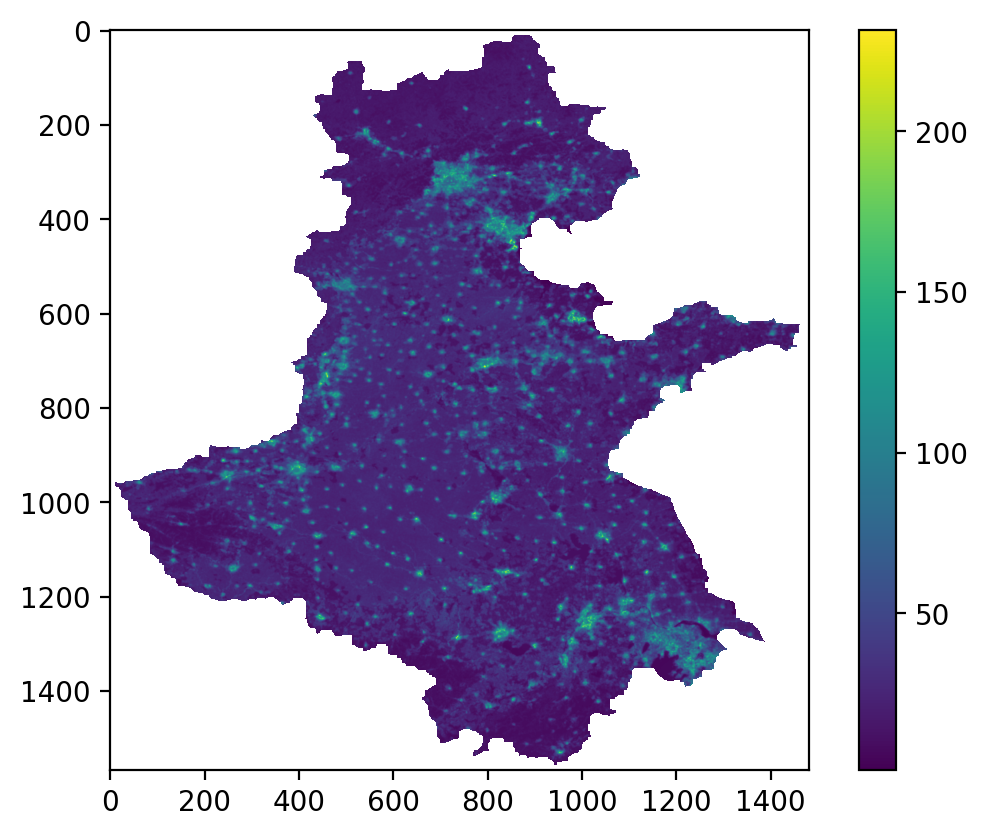

In [16]:
plt.imshow(summary_risk_array_gaussian[0,:,:])
plt.colorbar()

做一下自然间断点分类

In [17]:
def do_jenks(data, n_classes):
    import jenkspy
    breaks = jenkspy.jenks_breaks(data,n_classes)
    return breaks

In [18]:
risk_array_flatten = summary_risk_array_gaussian[~np.isnan(summary_risk_array_gaussian)].flatten()

In [19]:
risk_array_iidsample = [np.random.choice(risk_array_flatten,50000) for _ in range(100)]

In [20]:
levels = Parallel(n_jobs=joblib.cpu_count())(delayed(do_jenks)(i,5) for i in risk_array_iidsample)

In [21]:
levels = np.array(levels)
levels = np.mean(levels,axis=0)
print("final result: ",levels)
with open("levels.txt","w") as f:
    f.write(str(levels))

final result:  [  1.35242549  21.82254079  37.98107773  65.27000098 103.61316195
 237.67510798]


In [22]:
summary_risk_array = summary_risk_array_gaussian

In [23]:
summary_risk_set = xr.Dataset(
    {
        "summary_risk": (["time","y", "x"], summary_risk_array),
    },
    coords={
        "time": major_risk_set_standardized.time,
        "x": major_risk_set_standardized.x,
        "y": major_risk_set_standardized.y,
    },
)


In [24]:
summary_risk_set.rio.write_crs("epsg:4326", inplace=True)
summary_risk_set.rio.write_coordinate_system(inplace=True)

<xarray.Dataset>
Dimensions:       (time: 16, y: 1567, x: 1482)
Coordinates:
  * time          (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
  * x             (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7
  * y             (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
    spatial_ref   int32 0
Data variables:
    summary_risk  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

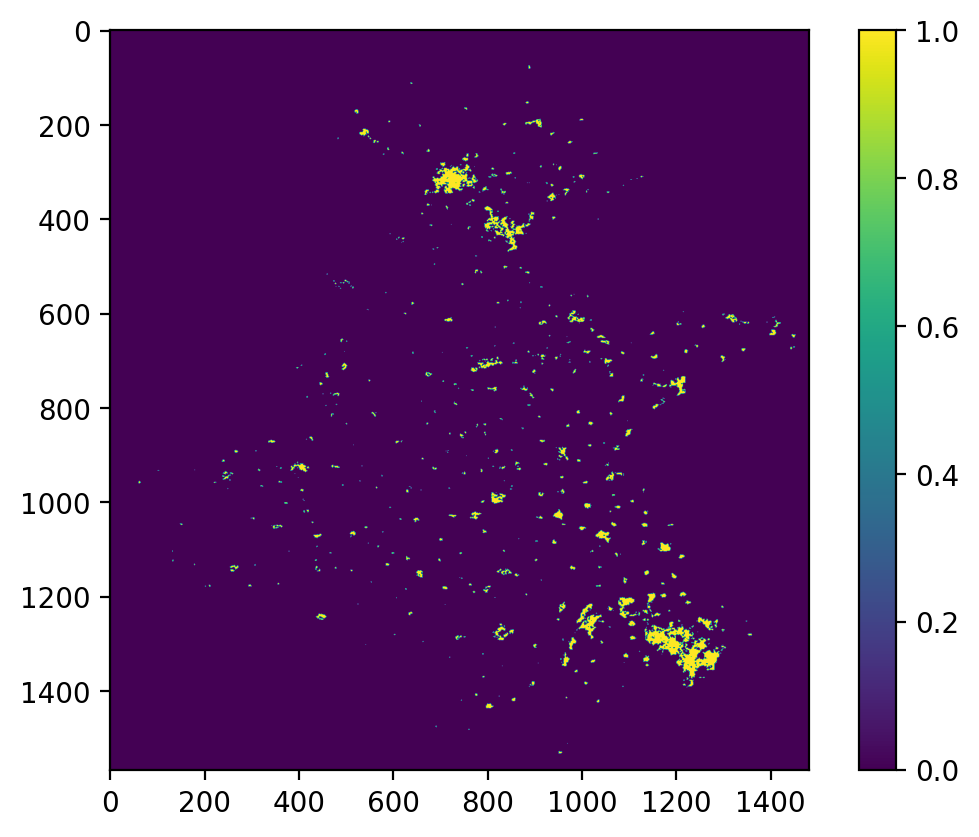

In [25]:
u=13
plt.imshow((summary_risk_array[u]<200)&(summary_risk_array[u]>100))
plt.colorbar()

In [26]:
summary_risk_set.to_netcdf(r"summary_risk.nc")

In [27]:
import py7zr
with py7zr.SevenZipFile(r"summary_risk.nc.7z", 'w') as archive:
    archive.write(r"summary_risk.nc")
    archive.write(r"levels.txt")
    archive.write(r"summary_risk.nc.aux.xml")

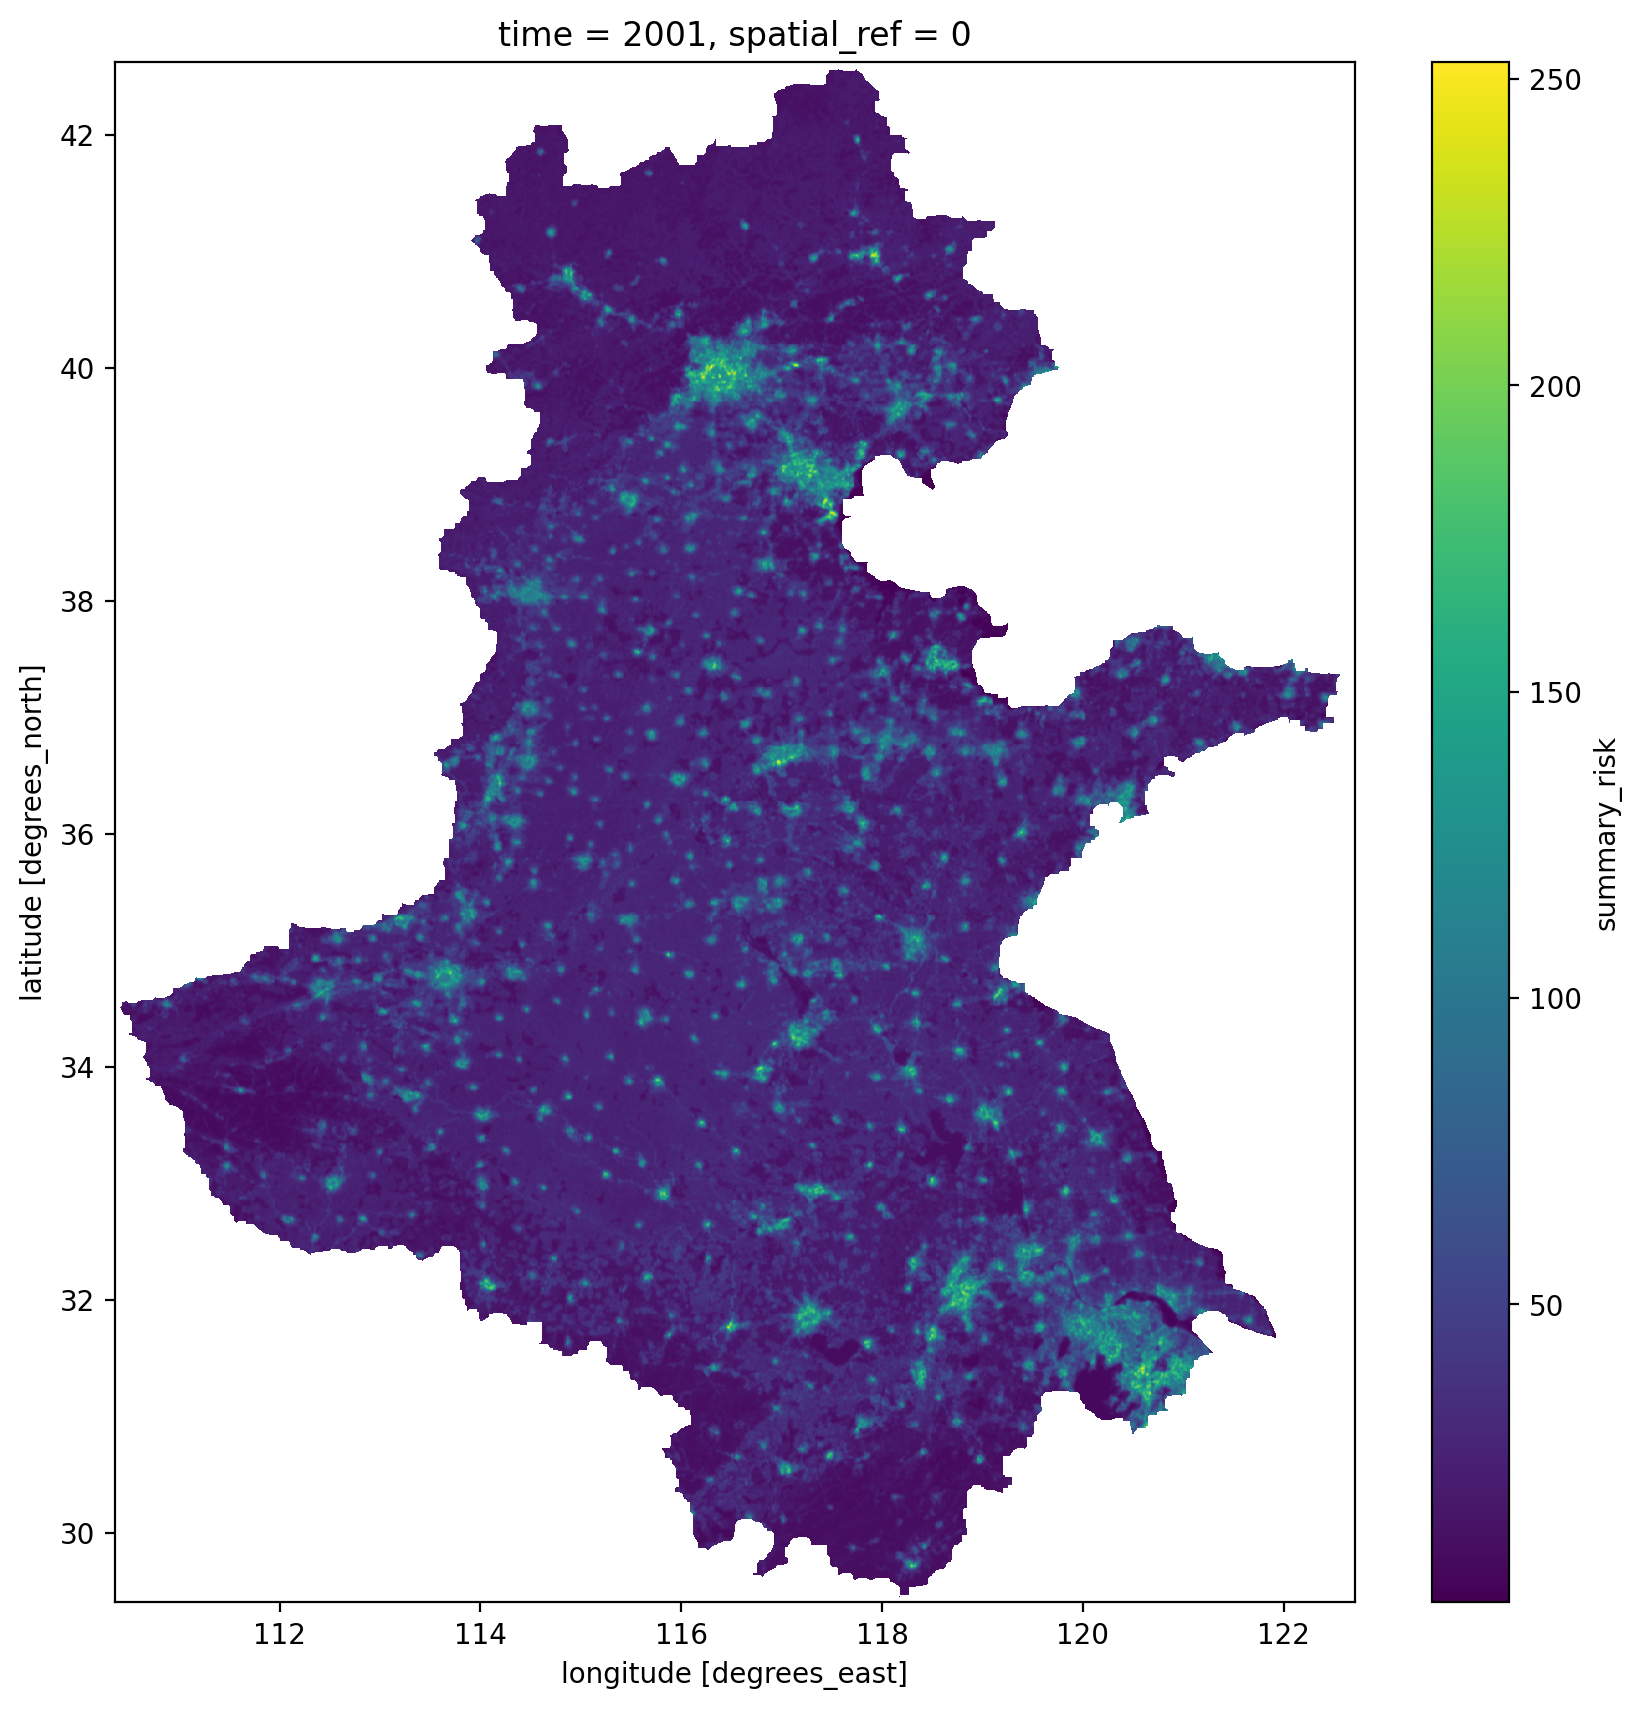

In [28]:
fig,ax = plt.subplots(figsize=(10,10))
summary_risk_set.summary_risk.loc[2001].plot(ax=ax)